In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
#import scipy.ndimage.morphology

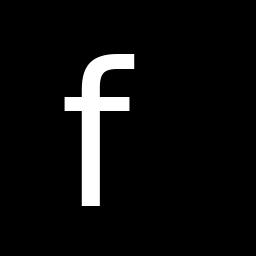

In [49]:
i = Image.new('L', (256, 256))
font = ImageFont.truetype('/usr/share/fonts/truetype/ttf-dejavu/DejaVuSans.ttf', 200)
draw = ImageDraw.Draw(i)
draw.text((60, 20), "f", font=font, fill=255)
i

# Jump flood

This is an implementation of the jump flood algorithm, which computes signed
distance fields. This is in pure Python so is very slow but serves as a
reference for making this run quickly on the GPU.

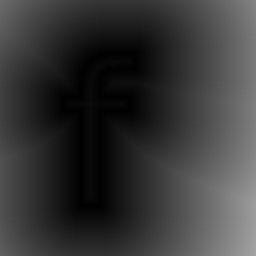

In [76]:
from itertools import product
from math import hypot
filled = np.array(i).astype('f4') > 0.5
sdf = np.zeros(filled.shape + (2,), dtype=float)

h, w = filled.shape

def in_bounds(pos):
    x, y = pos
    return 0 <= x < w and 0 <= y < h


inf = float('inf')
pots = [2 ** i for i in range(8, -1, -1)]
for step in pots:
    out = sdf.copy()
    for x, y in product(range(0, w), range(0, h)):
        inside = filled[x, y]
        adj = [
            (x - step, y - step),
            (x,        y - step),
            (x + step, y - step),
            (x - step, y),
            (x,        y),
            (x + step, y),
            (x - step, y + step),
            (x,        y + step),
            (x + step, y + step),
        ]
        min = inf
        closest = None
        for pos in filter(in_bounds, adj):
            adj_inside = filled[pos]
            if adj_inside != inside:
                point = pos
            else:
                dx, dy = sdf[pos]
                if dx or dy:
                    point = dx + pos[0], dy + pos[1]
                else:
                    continue
            dist = hypot(point[0] - x, point[1] - y)
            if dist < min:
                closest = point
                min = dist
        if min < inf:
            out[x, y] = closest[0] - x, closest[1] - y
    sdf = out

sdf = np.hypot(sdf[..., 0], sdf[..., 1])

Image.fromarray(sdf.astype('u1'))

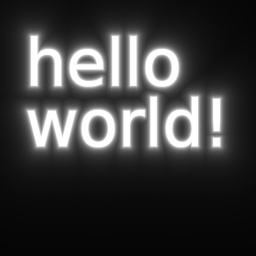

In [9]:
sdf = scipy.ndimage.morphology.distance_transform_edt(np.array(i).astype('f4') < 0.5) / 2
sdf = scipy.ndimage.gaussian_filter(sdf, 2)
sdf = scipy.ndimage.zoom(sdf, 1 / 8)

Image.fromarray((255 / (0.1 * sdf + 1)).astype('u1'))

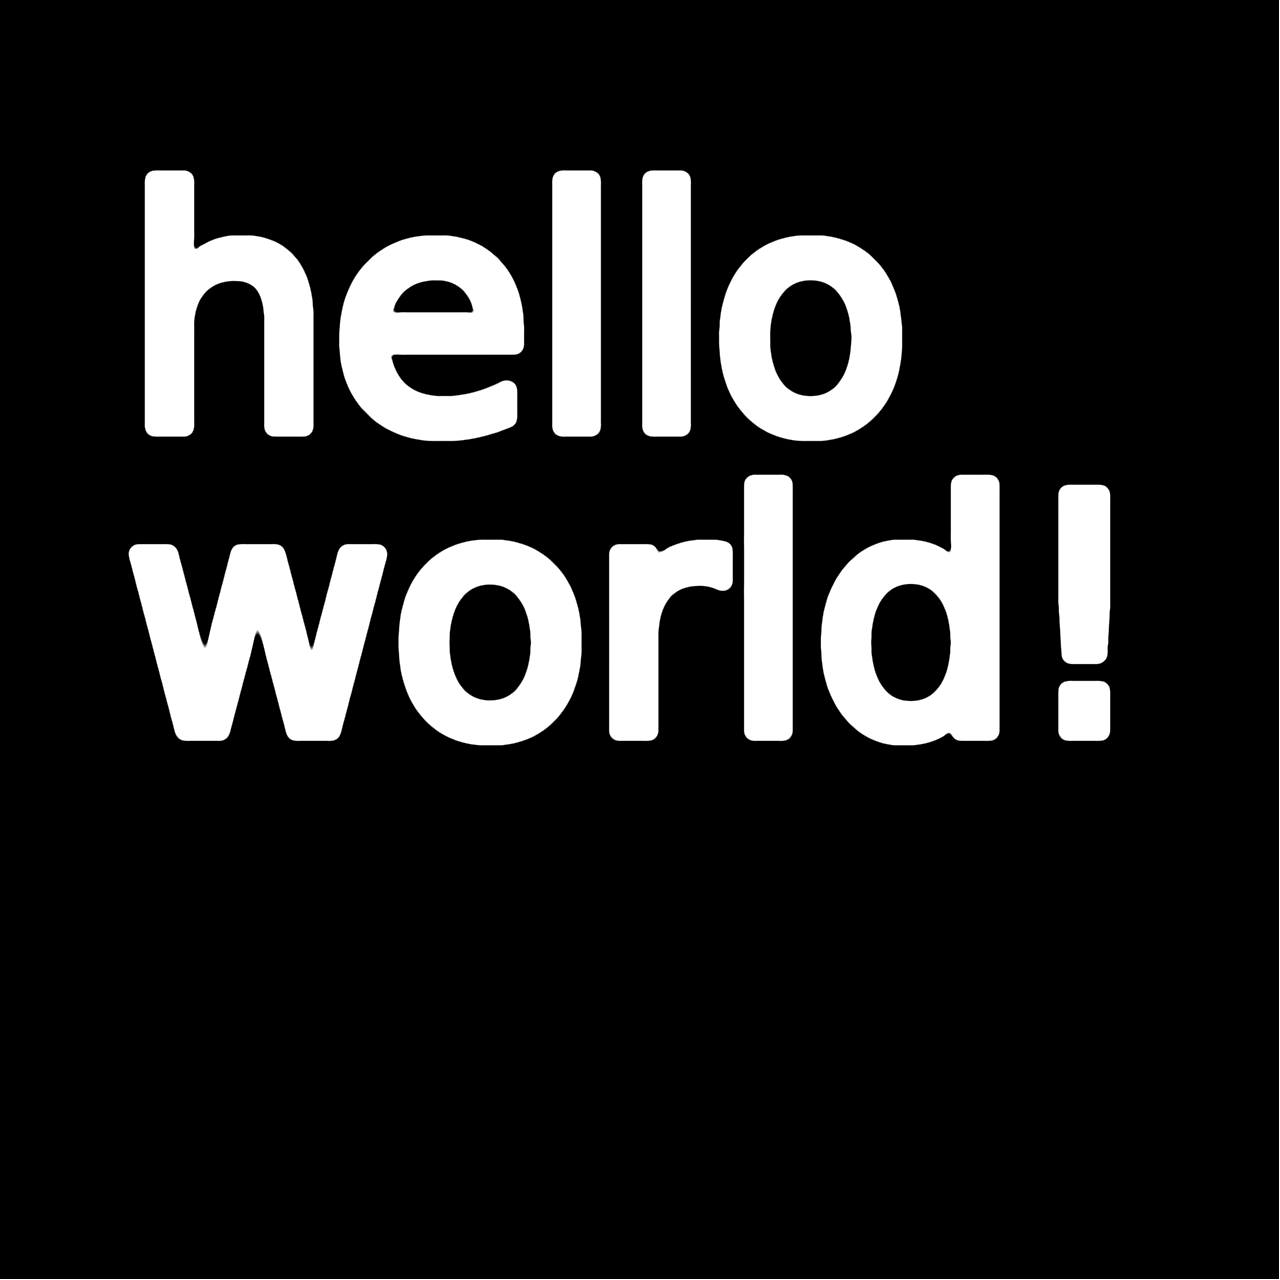

In [10]:
scale = 5
rad = 1.5 * scale + 1
large = scipy.ndimage.zoom(sdf, scale, order=2)
Image.fromarray((np.clip(rad - large * (scale / 5), 0, 1) * 255).astype('u1'))